# Introduction

# Preparatory analysis

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [273]:
data = pd.read_csv('data/diabetic_data.csv')

In [274]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

In [275]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Counting missing values for each feature

### Nan Values

In [276]:
data.shape

(101766, 50)

In [277]:
na_values = data.isna().sum(axis=0)

print(na_values[na_values > 0]/len(data) * 100)

max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


Apparently, max_glu_serum and A1Cresults are the only features with 'Nan' values. We can easily drop these columns, as these features are categorical so they cannot be inferred in any way. 


In [278]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [279]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [280]:
data = data.drop(columns=['max_glu_serum', 'A1Cresult'])

### Other missing values

Taking a look at the datasaet, it is clear that for some features missing values are indicated by a question mark rathen than being nan values. Let's count missing values for each column

In [281]:
for col in data.columns:
    missing_values = data.loc[data[col] == '?', col].value_counts()
    if len(missing_values.values > 0):
        print(col, missing_values.values/len(data) * 100)

race [2.23355541]
weight [96.85847926]
payer_code [39.55741603]
medical_specialty [49.0822082]
diag_1 [0.02063558]
diag_2 [0.35178743]
diag_3 [1.39830592]


From the results above, we find that the feature 'weight' is available only for 3% of the observations! This column can be dropped. We also find that 49% of observations do not have values for medical_speciality and 39% do not have values for payer_code. These two are both categorical variables, so we cannot use the mean or other statistics to replace missing values. So, they can easily be dropped
diag_1, diag_2 and diag_3 are diagnosis so they cannot be inferred. In a classification setting these features can cleary be useful. Suppose the primary diagnosis is correct: intuitevely, a patient with a correct diagnosis has a less probability of returning to the hospital rather than a patient with n incorrect diaagnosis. Rather than drop the columns it is wiser to drop the observations with missing diagnosis.

In [282]:
data = data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [283]:
#FARLO DOPO ANALISI ESPLORATIVA, ALTRIMENTI ALCUNE OSSERVAZIONI UTILI SI PERDONO

#labels = (data['diag_1'] == '?') | (data['diag_2'] == '?') | (data['diag_3'] == '?')
#data.drop(data[labels].index, inplace=True) # data[~labels] OP

In [284]:
data.shape

(101766, 45)

In [285]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data is now ready for the analysis pipeline!

# Renaiming some columns

To avoid potential failure when using statsmodel, we rename the columns that contains a '-' in their name.

In [286]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

## Changing unique values for some columns

Is this safe for logistic regression?

In [287]:
data.replace(['NO', '>30', '<30'], [0, 1, 2], inplace=True)
data.replace('No', 0, inplace=True)
data.replace('Ch', 1, inplace=True)
data.replace('Yes', 1, inplace=True)
data.replace(['Steady', 'Up', 'Down'], [1, 2, 3], inplace=True) #non ottimale

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_19568\3821934187.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(['NO', '>30', '<30'], [0, 1, 2], inplace=True)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_19568\3821934187.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('No', 0, inplace=True)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_19568\3821934187.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explic

In [288]:
data['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [289]:
dict = {'[0-10)':0, '[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6, '[70-80)':7, '[80-90)':8, '[90-100)':9}
data.replace(dict, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_19568\3077306244.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(dict, inplace=True)


In [290]:
data

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0,6,25,1,1,41,...,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,1,1,1,7,3,59,...,0,2,0,0,0,0,0,1,1,1
2,64410,86047875,AfricanAmerican,Female,2,1,1,7,2,11,...,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,Caucasian,Male,3,1,1,7,2,44,...,0,2,0,0,0,0,0,1,1,0
4,16680,42519267,Caucasian,Male,4,1,1,7,1,51,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,7,1,3,7,3,51,...,0,3,0,0,0,0,0,1,1,1
101762,443847782,74694222,AfricanAmerican,Female,8,1,4,5,5,33,...,0,1,0,0,0,0,0,0,1,0
101763,443854148,41088789,Caucasian,Male,7,1,1,7,1,53,...,0,3,0,0,0,0,0,1,1,0
101764,443857166,31693671,Caucasian,Female,8,2,3,7,10,45,...,0,2,0,0,0,0,0,1,1,0


# Exploratory data analysis

## What is the most frequent readmission type?

In [291]:
freqs = data['readmitted'].value_counts(normalize=True).sort_index()
print(freqs)

readmitted
0    0.539119
1    0.349282
2    0.111599
Name: proportion, dtype: float64


<Axes: xlabel='readmitted'>

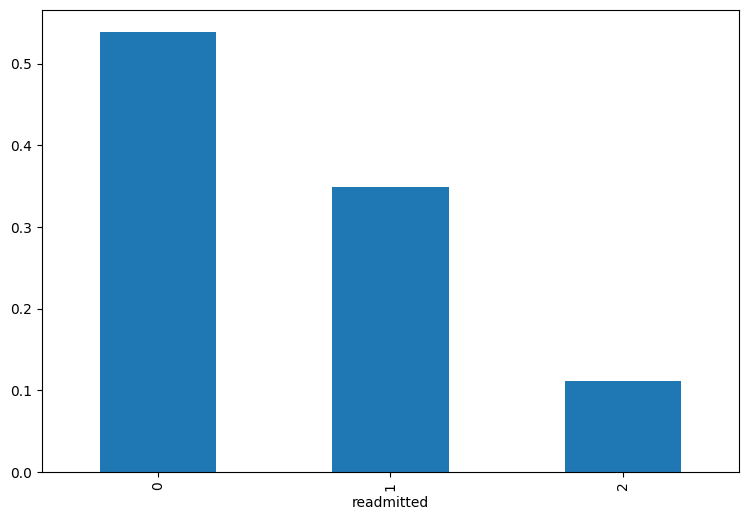

In [292]:
freqs.plot.bar(figsize=(9, 6))

Il 54% dei pazienti non è tornato in ospedale, il 35% è tornato in ospedale in un periodo che supera i 30 giorni e, infine, il restante 11% è tornato entro i 30 giorni. Da questo si evince che le valutazioni effettuate dai medici su #num pazienti si sono rivelate corrette e senza falle. ??

In [293]:
#data['readmitted'].plot.bar()

## What is the distribution of gender between readmissions?

## Distribution of gender

In [294]:
data['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [295]:
freqs = data['gender'].value_counts(normalize=True)
print(freqs)

gender
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: proportion, dtype: float64


<Axes: xlabel='gender'>

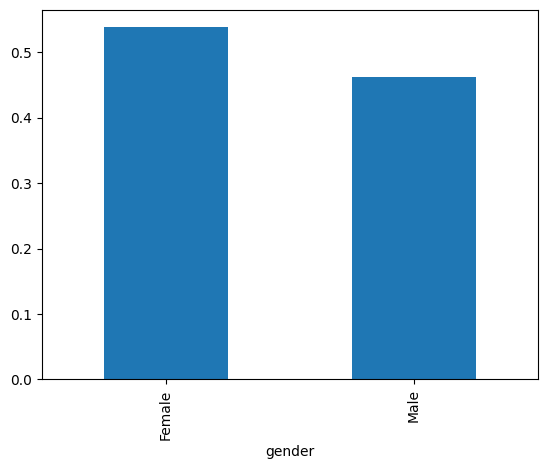

In [296]:
freqs[0:-1].plot.bar()

Let's count how many patients with 'unknown/invalid' gender are there in the dataset

In [297]:
data['gender'].value_counts().sort_index()

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

## Distribution of gender between readmissions

In [298]:
d = data[['gender', 'readmitted']]

freqs = (d.groupby('gender').value_counts(normalize=True))
print(freqs)

gender           readmitted
Female           0             0.530782
                 1             0.356767
                 2             0.112452
Male             0             0.548783
                 1             0.340601
                 2             0.110615
Unknown/Invalid  0             1.000000
Name: proportion, dtype: float64


<Axes: xlabel='gender,readmitted'>

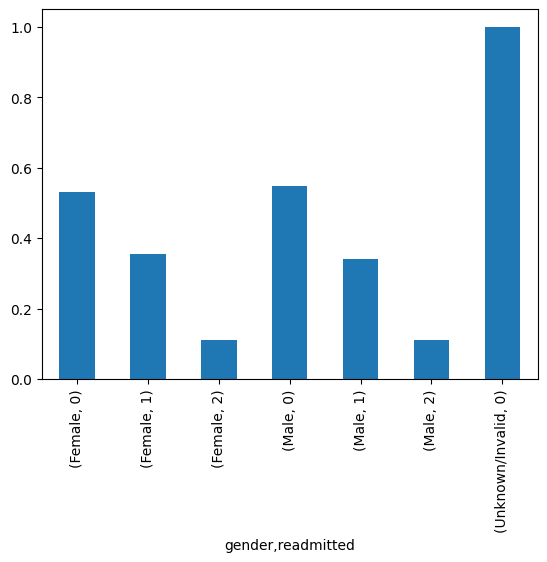

In [299]:
freqs.plot.bar()

## Distribution of age

ecdf = data['age'].value_counts(normalize=True).sort_index().cumsum()

plt.figure(figsize=(12, 8))
plt.title('Empirative Cumulative Distribution Function of Age')
plt.grid()
plt.plot(ecdf.index, ecdf.values)

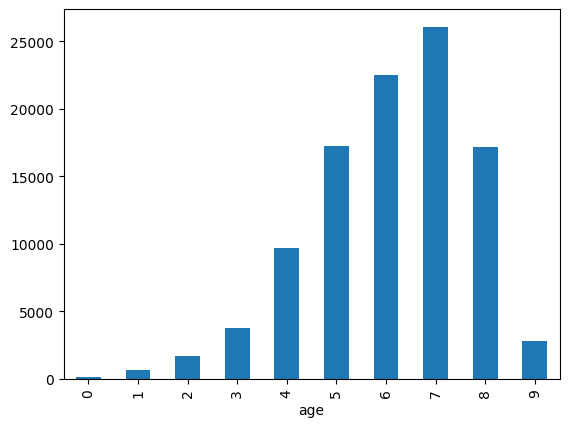

In [300]:
freqs = data['age'].value_counts().sort_index().plot.bar()

In [301]:
cont_table = pd.crosstab(index=data['age'], columns=data['readmitted'], normalize=True)
cont_table

readmitted,0,1,2
age,,,
0,0.001297,0.000255,0.000029
1,0.004196,0.002201,0.000393
2,0.008952,0.005011,0.002319
3,0.021264,0.011664,0.004166
4,0.052866,0.032211,0.010092
5,0.095032,0.058143,0.016391
6,0.118743,0.077600,0.024586
7,0.132893,0.093106,0.030157
8,0.087416,0.061150,0.020419


<Axes: xlabel='age'>

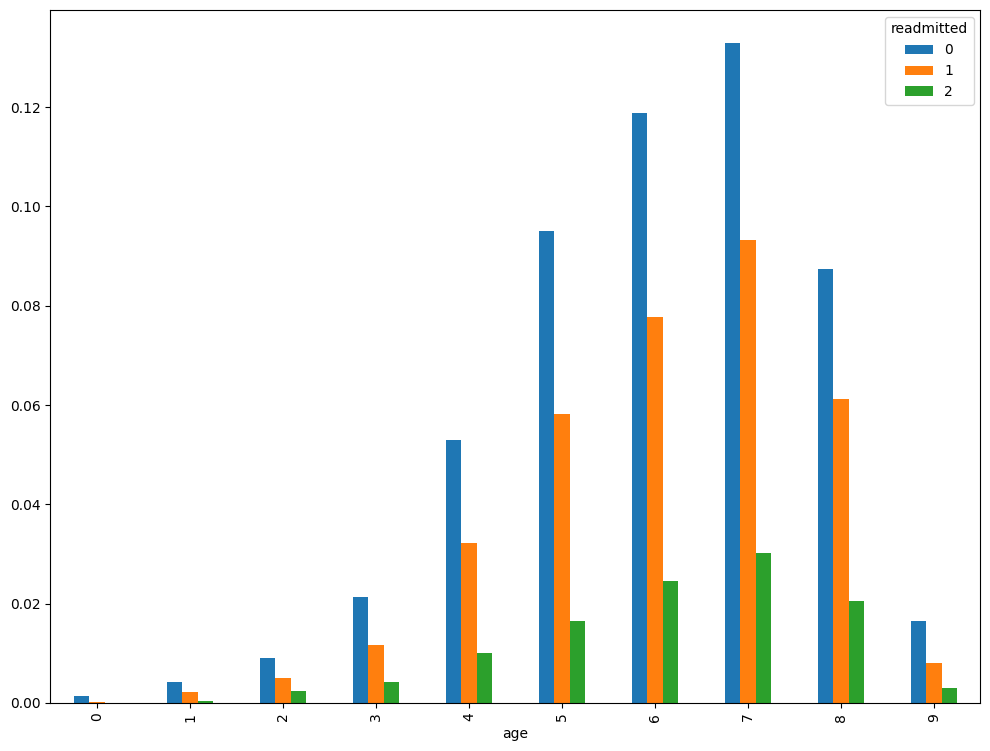

In [302]:
cont_table.plot.bar(figsize=(12, 9))

From the plot above, we can say that the distribution of age is similar between readmisssions types.

<Axes: >

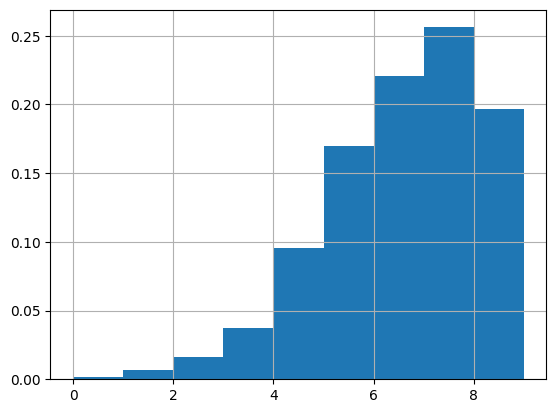

In [303]:
data['age'].hist(density=True, bins = range(0, 10))

....

# Inferential Analysis

## What is the average time in hospital?

In [304]:
mean = data['time_in_hospital'].mean()
print(mean)

4.395986871843248


From the results above, we find that the average time in hospital is 4 days. Is this due to chance or is it statistically significant? Let's run a statistical test and find out.

In [305]:
t, p = stats.ttest_1samp(data['time_in_hospital'], mean)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.0 
Alpha:  0.05


The p value is greater than the significance level, so we cannot reject the null hypothesis. <br>
This means that data do not provide enough evidence to say that the true time in hospital differs from 4 and an half day.

<Axes: >

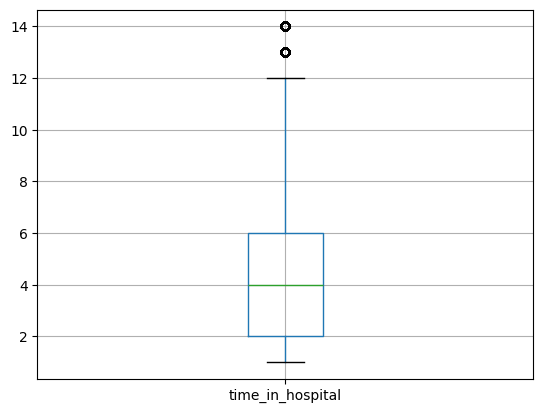

In [306]:
data.boxplot(column=['time_in_hospital'])

From the box plot above, we notice that values 13 and 14 are outliers. The median value is 4 and the third quantile is 6. 

## What is the average time in hospital between readmission classes?

In [307]:
not_readmitted = data.loc[data['readmitted'] == 0, 'time_in_hospital']
mean_not_readmitted = not_readmitted.mean()
print(mean_not_readmitted)

4.254429133858268


In [308]:
readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital']
mean_readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital'].mean()
print(mean_readmitted)

4.56157519935184


Again, is this due to chance or is it statistically significant? Let's run a statistical test to see if we can reject the hypothesis that the two means are equal. 

In [309]:
t, p = stats.ttest_ind(readmitted, not_readmitted)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  3.023396538894888e-60 
Alpha:  0.05


We can reject the null hyphothesis. It is safe to say that the two populations mean are different. 
Let's study the relationship between time_in_hospital and readmitted, using logistic regression.

Let's use a boxplot to study the distribution of time_in_hospital between readmissions.

<Axes: title={'center': 'time_in_hospital'}, xlabel='readmitted'>

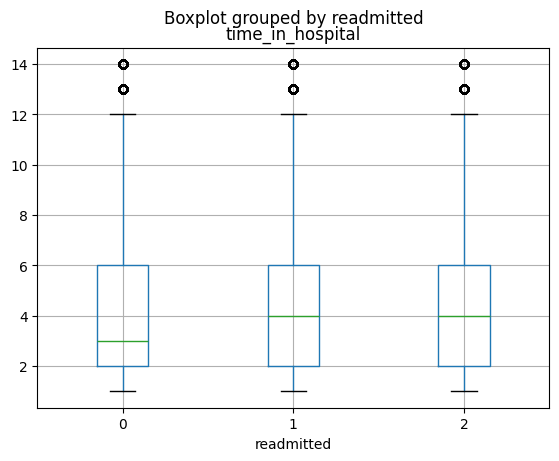

In [310]:
data.boxplot(by='readmitted', column='time_in_hospital') #todo: cambiare titolo

For classes 1 and 2, bloxplots are indentical. For class 0, the median is lower than the other two. This means that the distribution of time_in_hospital for patients of class 0 is not symmetrical.

In [311]:
## Altro?

## Logistic regression

Let's fit a logistic regressor to study the relationship between time_in_hospital and readmitted. To do thiis, let's first study if an increase of the variable "time_in_hospital" leads to an increase in the probability that a patient will be readmitted or not. 

In [312]:
from statsmodels.formula.api import logit, mnlogit

To do this, it is not necessary to use three class of readmissions, instead it sufficient to know that a patient has been readmitted or not.

In [313]:
view = data.replace({'readmitted': 2}, 1)

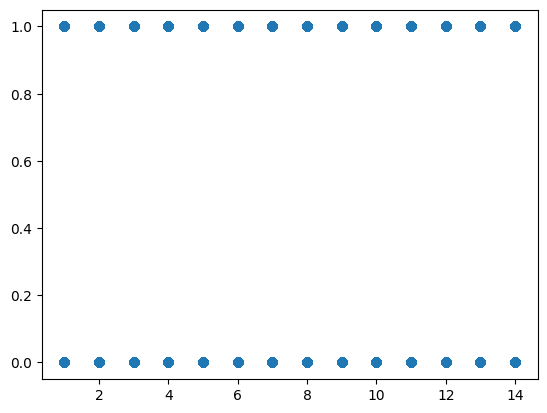

In [314]:
plt.scatter(x=view['time_in_hospital'], y=view['readmitted'])

### Simple logit regression

We can now fit a simple logit regressor

In [315]:
model = logit('readmitted ~ time_in_hospital', view).fit()

Optimization terminated successfully.
         Current function value: 0.688770
         Iterations 4


In [316]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                          Logit   Df Residuals:                   101764
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                0.001903
Time:                        20:02:47   Log-Likelihood:                -70093.
converged:                       True   LL-Null:                       -70227.
Covariance Type:            nonrobust   LLR p-value:                 4.311e-60
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3085      0.011    -27.469      0.000      -0.330      -0.286
time_in_hospital     0.0344      0.002     16.334      0.000       0.030       0.039
====================================================================================
"""

The pseudo-R^2 is very small: the model do not explain well the data.

In [317]:
np.exp(-0.3085)

np.float64(0.7345479521991701)

when time_in_hospital is set to 0, unrealistically, the odds of a patient being readmitted rather than not is 0.73. 

In [318]:
np.exp(0.0344)

np.float64(1.0349985233486143)

Without considering other variables, an extra day in hospital corresponds to a multiplicative increase in the odds of a patient being readmitted rather than not of 1.034. That is, if a patient spend an extra day in the hospital, the odds of being readmitted increases by a (1-1.034)*100 = 3.4%

In [319]:
model = mnlogit('readmitted ~ time_in_hospital', data).fit()

Optimization terminated successfully.
         Current function value: 0.943557
         Iterations 6


In [320]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                        MNLogit   Df Residuals:                   101762
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                0.001737
Time:                        20:02:49   Log-Likelihood:                -96022.
converged:                       True   LL-Null:                       -96189.
Covariance Type:            nonrobust   LLR p-value:                 2.868e-73
====================================================================================
    readmitted=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5537      0.012    -45.597      0.000      -0.578      -0.530
time_in_hospital     0.0274      0.002     11.967      0.000       0.023       0.032
------------------------------------------------------------------------------------
    readmitted=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.8254      0.019    -98.345      0.000      -1.862      -1.789
time_in_hospital     0.0556      0.003     16.819      0.000       0.049       0.062
====================================================================================
"""

In [321]:
np.exp(0.0556)

np.float64(1.0571747292596514)

In [322]:
data['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [323]:
data[data['gender'] == 'Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
30506,98634858,100695042,Other,Unknown/Invalid,7,3,1,1,1,5,...,0,0,0,0,0,0,0,1,1,0
75551,226864668,60524946,?,Unknown/Invalid,6,1,1,7,1,38,...,0,0,0,0,0,0,0,0,0,0
82573,257364294,78119847,?,Unknown/Invalid,7,1,22,7,8,59,...,0,0,0,0,0,0,0,1,1,0


In [324]:
data = data.drop(index=[30506, 75551, 82573])

## Multiple logit regressor

Let's define a function that build the formula automatically

In [325]:
def buildFormula(columns):
    formula = 'readmitted ~ ' + columns[0]
    
    for s in columns[1:-1]:
        formula = formula + ' + ' + s
        
    return formula

In [326]:
view = data.replace({'readmitted': 2}, 1)

Let's drop some variables about administrative data

In [327]:
view = view.drop(columns=['encounter_id', 'patient_nbr', 'race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'examide', 'citoglipton',
                          'diag_1', 'diag_2', 'diag_3'])

In [328]:
view.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [329]:
# gender + drop unknown

Variables "citoglipton" and "examide" has identical values for each observations. They are correlated, so we need to remove them in order to build a regression model.

In [330]:
data['citoglipton'].unique()

array([0])

In [331]:
data['examide'].unique()

array([0])

In [332]:
formula = buildFormula(columns=view.columns)

In [333]:
model = logit(formula, view).fit()

         Current function value: 0.653006
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [334]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101729
Method:                           MLE   Df Model:                           33
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                 0.05373
Time:                        20:02:51   Log-Likelihood:                -66452.
converged:                      False   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4069      0.038    -36.853      0.000      -1.482      -1.332
gender[T.Male]              -0.0474      0.013     -3.598      0.000      -0.073      -0.022
age                          0.0240      0.004      5.500      0.000       0.015       0.033
time_in_hospital             0.0109      0.003      4.255      0.000       0.006       0.016
num_lab_procedures           0.0014      0.000      3.935      0.000       0.001       0.002
num_procedures              -0.0454      0.004    -10.682      0.000      -0.054      -0.037
num_medications              0.0005      0.001      0.473      0.636      -0.002       0.003
number_outpatient            0.0840      0.006     13.977      0.000       0.072       0.096
number_emergency             0.2200      0.012     17.876      0.000       0.196       0.244
number_inpatient             0.3697      0.007     53.324      0.000       0.356       0.383
number_diagnoses             0.0780      0.004     21.012      0.000       0.071       0.085
metformin                   -0.0823      0.016     -5.119      0.000      -0.114      -0.051
repaglinide                  0.1187      0.045      2.645      0.008       0.031       0.207
nateglinide                  0.0400      0.071      0.565      0.572      -0.099       0.179
chlorpropamide               0.1967      0.193      1.019      0.308      -0.182       0.575
glimepiride                  0.0124      0.025      0.489      0.625      -0.037       0.062
acetohexamide               19.4977   1.53e+04      0.001      0.999   -2.99e+04       3e+04
glipizide                    0.0952      0.018      5.301      0.000       0.060       0.130
glyburide                    0.0308      0.019      1.650      0.099      -0.006       0.067
tolbutamide                 -0.4037      0.444     -0.910      0.363      -1.273       0.466
pioglitazone                 0.0802      0.024      3.340      0.001       0.033       0.127
rosiglitazone                0.0810      0.026      3.140      0.002       0.030       0.132
acarbose                     0.4011      0.113      3.535      0.000       0.179       0.624
miglitol                     0.5492      0.287      1.915      0.056      -0.013       1.111
troglitazone                 0.9092      1.225      0.742      0.458      -1.492       3.311
tolazamide                  -0.1985      0.327     -0.607      0.544      -0.839       0.442
insulin                      0.0394      0.011      3.572      0.000       0.018       0.061
glyburide_metformin          0.0535      0.074      0.720      0.472      -0.092       0.199
glipizide_metformin          0.6658      0.580      1.148      0.251      -0.470       1.802
glimepiride_pioglitazone    18.5163    1.1e+04      0.002      0.999   -2.15e+04    2.15e+04
metformin_rosiglitazone    -18.3185   7292.412     -0.003      0.998   -1.43e+04    1.43e+04
metformin_pioglitazone     -17.1774   8137.267     -0.002      0.998    -1.6e+0

There are various variables with a very high p-value, meaning that they aren't statistically significant. We can perform backward selection to build a better model

## Backward selection

ha senso?

view = view.drop(columns=['num_medications', 'nateglinide', 'glimepiride', 'chlorpropamide', 'acetohexamide', 'glyburide',
                          'tolbutamide', 'miglitol', 'troglitazone', 'tolazamide', 'change', 'glyburide_metformin',
                          'glipizide_metformin', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone'])

The variable with the highest p-value is acetohexamide, with a p-value of almost 1!

In [335]:
a = 0.05 #significance level
count = 1
while True:
    p = np.max(model.pvalues)
    if p > a:
        count = count + 1
        #backward selection
        i = np.argmax(model.pvalues)
        view = view.drop(columns=model.pvalues.index[i])
         
        formula = buildFormula(view.columns)
        model = logit(formula, view).fit()
    else:
        break

         Current function value: 0.653014
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.653020
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.653024
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653058
  

In [336]:
print(count, "variables removed")

17 variables removed


In [337]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101745
Method:                           MLE   Df Model:                           17
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                 0.05360
Time:                        20:03:02   Log-Likelihood:                -66461.
converged:                       True   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.4095      0.038    -37.078      0.000      -1.484      -1.335
gender[T.Male]        -0.0467      0.013     -3.555      0.000      -0.072      -0.021
age                    0.0247      0.004      5.668      0.000       0.016       0.033
time_in_hospital       0.0116      0.002      4.814      0.000       0.007       0.016
num_lab_procedures     0.0014      0.000      4.054      0.000       0.001       0.002
num_procedures        -0.0446      0.004    -11.301      0.000      -0.052      -0.037
number_outpatient      0.0840      0.006     14.001      0.000       0.072       0.096
number_emergency       0.2195      0.012     17.850      0.000       0.195       0.244
number_inpatient       0.3696      0.007     53.378      0.000       0.356       0.383
number_diagnoses       0.0781      0.004     21.303      0.000       0.071       0.085
metformin             -0.0872      0.014     -6.020      0.000      -0.116      -0.059
repaglinide            0.1107      0.044      2.491      0.013       0.024       0.198
glipizide              0.0839      0.016      5.191      0.000       0.052       0.116
pioglitazone           0.0744      0.023      3.242      0.001       0.029       0.119
rosiglitazone          0.0753      0.025      3.033      0.002       0.027       0.124
acarbose               0.3990      0.113      3.522      0.000       0.177       0.621
insulin                0.0303      0.008      3.973      0.000       0.015       0.045
diabetesMed            0.2173      0.020     11.129      0.000       0.179       0.256
======================================================================================
"""

We have slightly decreased the pseudo $R^2$: from $0.05373$ to $0.05360$

Despite performing backward selection, the pseudo $R^2$ very low: 0.05352. It seems that logistic regression is not a good model for explaining the dataset.

In [338]:
np.argmax(model.pvalues)

np.int64(11)

# Predictive Analysis

## PCA + logistic regression
## LDA
## Naive Bayes

# Conclusions